In [ ]:
import os, sys, time, random
import h5py
import numpy as np
import pandas as pd

In [ ]:
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf

In [ ]:
batch_size = 30
epochs = 100
latent_dim = 256
num_samples = 1000
data_path = "\/content/Data - Sheet1-6.csv"

In [ ]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

data = pd.read_csv("/content/Data - Sheet1-6.csv")

In [ ]:
data['Informal'].astype(str)
data['Formal'].astype(str)
data.dropna()

,Formal,Informal
0,I don't think that page gave me viruses.,that page did not give me viroses(i think)
1,"I watch it everyday, my favorite charachter is...","of corse i be wachin it evry day, my fav chara..."
2,Funbrain.com and runescape.com are great for f...,runescape.com (my kids love it) & funbrain.com...
3,He was on the Late Night show with Conan O'Bri...,Is he gay?He was on Late Night with Conan O'Br...
4,Mel Gibson is a strong believed of God.,"id have to say mel gibson, a strong [god] beli..."
...,...,...
1008,"No, Slim Shady is only his nickname.",slim shady is his nickname (duh!)
1009,"The In-Laws movie isn't a holiday movie, but i...",the movie The In-Laws not exactly a holiday mo...
1010,"For real hip-hop, see Kriss Kross Live & Die.",kriss kross live & die for real hip-hop
1011,"It's been a while, but I believe Momo ends up ...",Peach Girl - been a while but I think Momo end...


In [ ]:
data['Informal'] = "\t"+data['Informal']+"\n"
data['Formal'] = "\t"+data['Formal']+"\n"


In [ ]:
for i in data['Informal']:
  input_texts.append(i)
  for char in str(i):
    if char not in input_characters:
      input_characters.add(char)

for i in data['Formal']:
  target_texts.append(str(i))
  for char in str(i):
    if char not in target_characters:
      target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(str(txt)) for txt in input_texts])
max_decoder_seq_length = max([len(str(txt)) for txt in target_texts])

In [ ]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 1013
Number of unique input tokens: 103
Number of unique output tokens: 84
Max sequence length for inputs: 126
Max sequence length for outputs: 159


In [ ]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')


In [ ]:


for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(str(input_text)):
        encoder_input_data[i,t,input_token_index[char]] = 1
    for t, char in enumerate(str(target_text)):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i,t, target_token_index[char]] = 1
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i,t-1, target_token_index[char]] = 1.

In [ ]:
print(encoder_input_data)

[[[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


In [ ]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.summary()
# print(model.layers[-1].input)
print(model.layers[-3].output)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 103)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 84)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        368640      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [ ]:
print("encoder_input_data shape:",encoder_input_data.shape)
print("decoder_input_data shape:",decoder_input_data.shape)
print("decoder_target_data shape:",decoder_target_data.shape)

encoder_input_data shape: (1013, 126, 103)
decoder_input_data shape: (1013, 159, 84)
decoder_target_data shape: (1013, 159, 84)


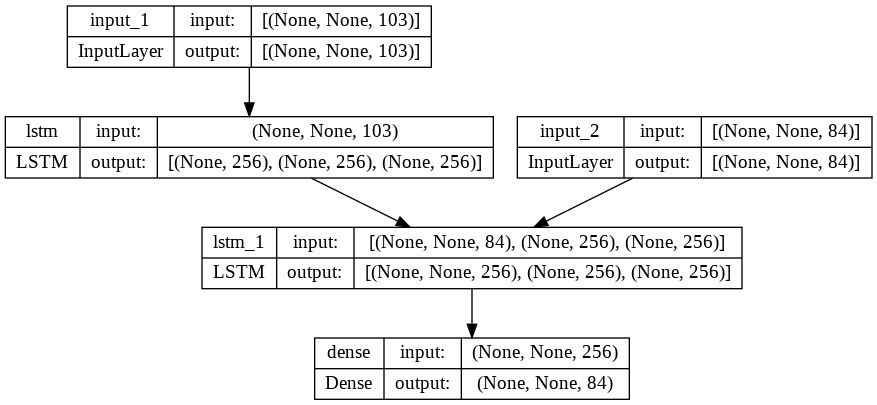

In [ ]:
plot_model(model,show_shapes=True)

In [ ]:
# Run training
from keras.optimizers import * 
model.compile(optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001), loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs, 
          validation_split=0.2)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


27/27 [==============================] - 27s 860ms/step - loss: 1.1756 - val_loss: 1.1395
Epoch 2/100
27/27 [==============================] - 25s 915ms/step - loss: 1.1015 - val_loss: 1.1342
Epoch 3/100
27/27 [==============================] - 23s 856ms/step - loss: 1.0971 - val_loss: 1.1275
Epoch 4/100
27/27 [==============================] - 23s 858ms/step - loss: 1.0932 - val_loss: 1.1290
Epoch 5/100
27/27 [==============================] - 22s 821ms/step - loss: 1.0916 - val_loss: 1.1237
Epoch 6/100
27/27 [==============================] - 22s 831ms/step - loss: 1.0901 - val_loss: 1.1230
Epoch 7/100
27/27 [==============================] - 25s 935ms/step - loss: 1.0894 - val_loss: 1.1178
Epoch 8/100
27/27 [==============================] - 22s 815ms/step - loss: 1.0969 - val_loss: 1.1237
Epoch 9/100
27/27 [==============================] - 22s 821ms/step - loss: 1.0921 - val_loss: 1.1254
Epoch 10/100
27/27 [==============================] - 23s 862ms/step - loss: 1.0916 - val_loss

In [ ]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [ ]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [ ]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 41ms/step
-
Input sentence: 	Day Three - I receive the movie they sent me.

Decoded sentence: I                                                                                                                                                               
1/1 [==============================] - 0s 33ms/step
-
Input sentence: 	LOL*  Gotta give credit were credit is due!!

Decoded sentence: I                                                                                                                                                               
1/1 [==============================] - 0s 28ms/step
-
Input sentence: 	avenge sevenfold  or  my chemical romance

Decoded sentence: I                                                                                                                                                               
1/1 [==============================] - 0s 44ms/step
-
Input sen